# Word Embedding Visualizations.

Name: Anthony Kevin Oktavius

Here, we'll experiment with various embedding layer, with these following techniques.

* TF-IDF
* Count Vectorizer
* Word2Vec
* Neural network embedding layer.

As time passes, I'll try to add various  techniques. We also use dimensionality reduction technique to reduce the dimension of each layers, so we can visualize the relationshop between each words with matplotlib.

Library Import

In [ ]:
# ! pip install plotly-resampler

In [1]:
import numpy as np
import zipfile
import gc
import pickle
import cv2
import math
import warnings
import random
import string
import os
import glob
import plotly
import gensim
import re
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
# import torchmetrics
import torch.nn.functional as F
import PIL
import torch.utils.data as data_utils
import pickle
import collections
import nltk
import plotly.express as px

# import pytorch_lightning as pl
import imutils
import zipfile

# from plotly_resampler import register_plotly_resampler
# from plotly_resampler import FigureResampler, FigureWidgetResampler
from gensim.models import KeyedVectors
from nltk.corpus import words, stopwords
from wordcloud import WordCloud
from PIL import Image
from torch.utils.data import Dataset
from collections import defaultdict
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA, TruncatedSVD
from tensorflow.python.client import device_lib
from zipfile import ZipFile
from IPython import display
from torchvision import models, transforms
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

Dataset Loading with OpinRank dataset.

In [ ]:
! wget https://www.cs.cmu.edu/~./enron/enron_mail_20150507.tar.gz

Unzip the dataset in tar file format.

In [ ]:
! tar -xzf /content/enron_mail_20150507.tar.gz

## Data Preparation

Gather all of the email paths from all-documents folder.

In [ ]:
root_path = "maildir/"
email_paths_from_all_documents_folder = glob.glob(os.path.join(root_path, "*/all_documents/*."))
print(email_paths_from_all_documents_folder[:10])

['maildir/south-s/all_documents/63.', 'maildir/south-s/all_documents/86.', 'maildir/south-s/all_documents/22.', 'maildir/south-s/all_documents/14.', 'maildir/south-s/all_documents/27.', 'maildir/south-s/all_documents/91.', 'maildir/south-s/all_documents/77.', 'maildir/south-s/all_documents/2.', 'maildir/south-s/all_documents/90.', 'maildir/south-s/all_documents/21.']


Get body email data, after X-Filename.

In [ ]:
print("Sample Email data: ")

def read_file(path):
  return open(path, "r", errors='ignore')

def get_removed_components_email_text(text):
  texts_per_line = text.split("\n")

  full_email_text_per_line = []

  email_components = [
    "Message-ID: ", "Date: ", "From: ",
    "To: ", "Subject: ", "Mime-Version: ",
    "Content-Type: ", "Content-Transfer-Encoding: ", "X-From: ",
    "X-cc: ", "X-bcc: ", "X-Folder: ", "X-FileName: ",
    "X-Origin: ", "X-Filename: ", "cc: ", "@enron.com",
  ]
  NOT_FOUND = -1

  for text_per_line in text.split("\n"):
    is_exist_component = False
    for component in email_components:
      if text_per_line.find(component) != NOT_FOUND:
        is_exist_component = True
        break
    if is_exist_component == False:
      full_email_text_per_line.append(text_per_line)

  return " ".join(full_email_text_per_line)

sample_file = read_file(email_paths_from_all_documents_folder[0])
sample_body_email_data = get_removed_components_email_text(sample_file.read())

print(sample_body_email_data)

Sample Email data: 
	agcdu6@triax.com, anita.reubens@swgas.com, bblanar@coral-energy.com,  	bob.mattice@engageenergy.com, bob.mattice@engageenergy.com,  	browning@wasatchenergy.com, bruce.langmade@fortjamesmail.com,  	bymank@wdni.com, cards@wdni.com, caver_ordal@pgn.com,  	ccoyle@americansoda.com, cmcgra@puget.com, cpavlica@enerad.com,  	craig.provenzano@powersrc.com, cridin@puget.com, cslaman@usg.com,  	cwduke@duke-energy.com, darena@national-energy.com,  	dave.dungan@weyerhaeuser.com, deborahs@kimballenergy.com,  	geek@bp.com, gilesmh@bp.com, janderson@clarkpud.com,  	jane@itcoworld.com, jennifer_owen@pgn.com,  	jmmcarthur@duke-energy.com, jsanders@clarkpud.com,  	kims@kimballenergy.com, klambe@puget.com,  	mcano@enerad.com, michelle_hunter@pgn.com,  	niels_a_vervloet@reliantenergy.com, pschmidt@kimballresources.com,  	ramperms@bp.com, rcooper@usg.com, rfm@nwnatural.com,  	robert.harp@engageenergy.com, robert.harp@engageenergy.com,  	tdizona@coral-energy.com, tjmi@dynegy.com,  	tom.m

Putting it all together

In [ ]:
def get_dataset():
  root_path = "maildir/"
  email_paths_from_all_documents_folder = glob.glob(os.path.join(root_path, "*/all_documents/*."))

  dataset = []

  for email_path in email_paths_from_all_documents_folder:
    file_ = read_file(email_path)
    email_body = get_removed_components_email_text(file_.read())
    dataset.append(email_body)

  return dataset

dataset = get_dataset()
print(f"Number of data: {len(dataset)}")
dataset[:10]

Number of data: 128103


['\tagcdu6@triax.com, anita.reubens@swgas.com, bblanar@coral-energy.com,  \tbob.mattice@engageenergy.com, bob.mattice@engageenergy.com,  \tbrowning@wasatchenergy.com, bruce.langmade@fortjamesmail.com,  \tbymank@wdni.com, cards@wdni.com, caver_ordal@pgn.com,  \tccoyle@americansoda.com, cmcgra@puget.com, cpavlica@enerad.com,  \tcraig.provenzano@powersrc.com, cridin@puget.com, cslaman@usg.com,  \tcwduke@duke-energy.com, darena@national-energy.com,  \tdave.dungan@weyerhaeuser.com, deborahs@kimballenergy.com,  \tgeek@bp.com, gilesmh@bp.com, janderson@clarkpud.com,  \tjane@itcoworld.com, jennifer_owen@pgn.com,  \tjmmcarthur@duke-energy.com, jsanders@clarkpud.com,  \tkims@kimballenergy.com, klambe@puget.com,  \tmcano@enerad.com, michelle_hunter@pgn.com,  \tniels_a_vervloet@reliantenergy.com, pschmidt@kimballresources.com,  \tramperms@bp.com, rcooper@usg.com, rfm@nwnatural.com,  \trobert.harp@engageenergy.com, robert.harp@engageenergy.com,  \ttdizona@coral-energy.com, tjmi@dynegy.com,  \ttom.m

Remove Punctuations from the dataset.

In [ ]:
def get_removed_duplicated_space_in_string(my_string):
    return " ".join(my_string.split())

def get_erased_punctuations(text):
    list_of_punctuations = string.punctuation + "\‘="
    final_text = text

    for punc in list_of_punctuations:
      final_text = final_text.replace(punc, "")

    final_text = get_removed_duplicated_space_in_string(final_text)

    return final_text

erased_punctuations_dataset = []

for datum in dataset:
  erased_punctuations_datum = get_erased_punctuations(datum)
  erased_punctuations_dataset.append(erased_punctuations_datum)

erased_punctuations_dataset[:10]

['agcdu6triaxcom anitareubensswgascom bblanarcoralenergycom bobmatticeengageenergycom bobmatticeengageenergycom browningwasatchenergycom brucelangmadefortjamesmailcom bymankwdnicom cardswdnicom caverordalpgncom ccoyleamericansodacom cmcgrapugetcom cpavlicaeneradcom craigprovenzanopowersrccom cridinpugetcom cslamanusgcom cwdukedukeenergycom darenanationalenergycom davedunganweyerhaeusercom deborahskimballenergycom geekbpcom gilesmhbpcom jandersonclarkpudcom janeitcoworldcom jenniferowenpgncom jmmcarthurdukeenergycom jsandersclarkpudcom kimskimballenergycom klambepugetcom mcanoeneradcom michellehunterpgncom nielsavervloetreliantenergycom pschmidtkimballresourcescom rampermsbpcom rcooperusgcom rfmnwnaturalcom robertharpengageenergycom robertharpengageenergycom tdizonacoralenergycom tjmidynegycom tommckayengageenergycom tommckayengageenergycom valyildirokpgncom wharlankimballresourcescom zcournsnationalfuelcom jshadieidahopowercom Category SHORTTERM FIRM CAPACITY Subcategory NWP OFFERS Not

Remove integers from dataset.

In [ ]:
def erase_all_digits_from_sentence(sentence):
    digits = string.digits
    table = str.maketrans('', '', digits)
    new_string = sentence.translate(table)
    return new_string

erased_all_digits_dataset = []

for datum in erased_punctuations_dataset:
  all_digits_erased_datum = erase_all_digits_from_sentence(datum)
  erased_all_digits_dataset.append(all_digits_erased_datum)

erased_all_digits_dataset[:10]

['agcdutriaxcom anitareubensswgascom bblanarcoralenergycom bobmatticeengageenergycom bobmatticeengageenergycom browningwasatchenergycom brucelangmadefortjamesmailcom bymankwdnicom cardswdnicom caverordalpgncom ccoyleamericansodacom cmcgrapugetcom cpavlicaeneradcom craigprovenzanopowersrccom cridinpugetcom cslamanusgcom cwdukedukeenergycom darenanationalenergycom davedunganweyerhaeusercom deborahskimballenergycom geekbpcom gilesmhbpcom jandersonclarkpudcom janeitcoworldcom jenniferowenpgncom jmmcarthurdukeenergycom jsandersclarkpudcom kimskimballenergycom klambepugetcom mcanoeneradcom michellehunterpgncom nielsavervloetreliantenergycom pschmidtkimballresourcescom rampermsbpcom rcooperusgcom rfmnwnaturalcom robertharpengageenergycom robertharpengageenergycom tdizonacoralenergycom tjmidynegycom tommckayengageenergycom tommckayengageenergycom valyildirokpgncom wharlankimballresourcescom zcournsnationalfuelcom jshadieidahopowercom Category SHORTTERM FIRM CAPACITY Subcategory NWP OFFERS Noti

Lowercase All Letters.

In [ ]:
def lowercase_letters(sentence):
    return sentence.lower()

lowecase_text_dataset = []

for datum in erased_all_digits_dataset:
  lowercase_letters_datum = lowercase_letters(datum)
  lowecase_text_dataset.append(lowercase_letters_datum)

lowecase_text_dataset[:10]

['agcdutriaxcom anitareubensswgascom bblanarcoralenergycom bobmatticeengageenergycom bobmatticeengageenergycom browningwasatchenergycom brucelangmadefortjamesmailcom bymankwdnicom cardswdnicom caverordalpgncom ccoyleamericansodacom cmcgrapugetcom cpavlicaeneradcom craigprovenzanopowersrccom cridinpugetcom cslamanusgcom cwdukedukeenergycom darenanationalenergycom davedunganweyerhaeusercom deborahskimballenergycom geekbpcom gilesmhbpcom jandersonclarkpudcom janeitcoworldcom jenniferowenpgncom jmmcarthurdukeenergycom jsandersclarkpudcom kimskimballenergycom klambepugetcom mcanoeneradcom michellehunterpgncom nielsavervloetreliantenergycom pschmidtkimballresourcescom rampermsbpcom rcooperusgcom rfmnwnaturalcom robertharpengageenergycom robertharpengageenergycom tdizonacoralenergycom tjmidynegycom tommckayengageenergycom tommckayengageenergycom valyildirokpgncom wharlankimballresourcescom zcournsnationalfuelcom jshadieidahopowercom category shortterm firm capacity subcategory nwp offers noti

Remove stopwords from the dataset.

In [ ]:
def get_stopwords_from_nltk(language = 'english'):
  nltk.download('stopwords')
  return stopwords.words(language)

def get_stopwords_removed_sentence(sentence, list_of_stopwords = get_stopwords_from_nltk()):
  new_sentence = ""

  for word in sentence.split(" "):
    if word not in list_of_stopwords:
      new_sentence += f"{word} "

  return new_sentence

removed_stopwords_dataset = []

for datum in lowecase_text_dataset:
  removed_stopwords_datum = get_stopwords_removed_sentence(datum)
  removed_stopwords_dataset.append(removed_stopwords_datum)

removed_stopwords_dataset[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['agcdutriaxcom anitareubensswgascom bblanarcoralenergycom bobmatticeengageenergycom bobmatticeengageenergycom browningwasatchenergycom brucelangmadefortjamesmailcom bymankwdnicom cardswdnicom caverordalpgncom ccoyleamericansodacom cmcgrapugetcom cpavlicaeneradcom craigprovenzanopowersrccom cridinpugetcom cslamanusgcom cwdukedukeenergycom darenanationalenergycom davedunganweyerhaeusercom deborahskimballenergycom geekbpcom gilesmhbpcom jandersonclarkpudcom janeitcoworldcom jenniferowenpgncom jmmcarthurdukeenergycom jsandersclarkpudcom kimskimballenergycom klambepugetcom mcanoeneradcom michellehunterpgncom nielsavervloetreliantenergycom pschmidtkimballresourcescom rampermsbpcom rcooperusgcom rfmnwnaturalcom robertharpengageenergycom robertharpengageenergycom tdizonacoralenergycom tjmidynegycom tommckayengageenergycom tommckayengageenergycom valyildirokpgncom wharlankimballresourcescom zcournsnationalfuelcom jshadieidahopowercom category shortterm firm capacity subcategory nwp offers noti

Remove words that are not from the dictionary.

In [ ]:
def get_words_from_corpus():
  return words.words("en")

def get_filter_english_words_dict(additional_words = []):
  eng_word_mapping_dict = dict()
  words_from_corpus = get_words_from_corpus()

  for word in words_from_corpus:
    eng_word_mapping_dict[word] = word

  for word in additional_words:
    eng_word_mapping_dict[word] = word

  return eng_word_mapping_dict

def get_filtered_sentence_from_corpus(sentence, words_from_corpus_dict):

  new_sentence = ""
  for word in sentence.split(" "):
    try:
      new_sentence += f"{words_from_corpus_dict[word]} "
    except KeyError as e:
      pass

  return new_sentence

filtered_sentence_from_corpus_dataset = []
eng_word_mapping_dict = get_filter_english_words_dict()
for datum in removed_stopwords_dataset:
  sentence = get_filtered_sentence_from_corpus(datum, eng_word_mapping_dict)
  filtered_sentence_from_corpus_dataset.append(sentence)

filtered_sentence_from_corpus_dataset[:10]

['category firm capacity subcategory notice text notification northwest notice available potentially available firm transportation capacity note limited term transportation capacity added notice capacity available service total available receipt point delivery point date b kern b kern c plant rio arches national park vernal dutch e road inland paper f f g creek g creek g creek h opal plant western center painter muddy creek kern painter muddy creek kern j western center crossover k western center clay basin l crossover green crossover clay basin crossover clay basin n green clay basin clay basin chevron vernal p clay basin q clay basin rifle q clay basin rifle r clay basin soda ash ut gas green green u rifle v greasewood clay basin w quick cycle green x kern river green z north green aa sand west clay basin calf canyon kern river foundation green grand valley green grand gas green plant green plant green plant green plant green plant grand junction plant grand junction plant plant blan

Save the dataset for future use.

In [ ]:
save_path = "/content/drive/MyDrive/Models/enron_email_dataset.pickle"
pickle.dump(filtered_sentence_from_corpus_dataset, open(save_path, "wb"))

Load the dataset

In [3]:
save_path = "/content/drive/MyDrive/Models/enron_email_dataset.pickle"
preprocessed_dataset = pickle.load(open(save_path, "rb"))
preprocessed_dataset[:2]

['category firm capacity subcategory notice text notification northwest notice available potentially available firm transportation capacity note limited term transportation capacity added notice capacity available service total available receipt point delivery point date b kern b kern c plant rio arches national park vernal dutch e road inland paper f f g creek g creek g creek h opal plant western center painter muddy creek kern painter muddy creek kern j western center crossover k western center clay basin l crossover green crossover clay basin crossover clay basin n green clay basin clay basin chevron vernal p clay basin q clay basin rifle q clay basin rifle r clay basin soda ash ut gas green green u rifle v greasewood clay basin w quick cycle green x kern river green z north green aa sand west clay basin calf canyon kern river foundation green grand valley green grand gas green plant green plant green plant green plant green plant grand junction plant grand junction plant plant blan

Get the latest dataset, if the data is different from the saved dataset.

In [ ]:
preprocessed_dataset = filtered_sentence_from_corpus_dataset

## Data Visualization

Performing Word Cloud.

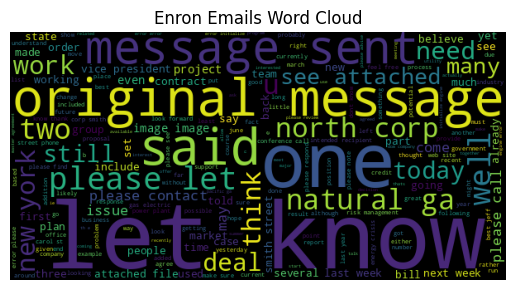

In [ ]:
def visualize_word_cloud(documents, title, width, height):
    word_cloud = WordCloud(width = width, height = height, random_state = 100)
    text_from_all_documents = " ".join(documents)
    word_cloud.generate(text_from_all_documents)

    plt.title(title)
    plt.axis("off")
    plt.imshow(word_cloud)
    plt.show()

visualize_word_cloud(
  preprocessed_dataset,
  title = "Enron Emails Word Cloud",
  width = 600,
  height = 300
)

Analyze bigrams

In [ ]:
flattened_words = [" ".join(preprocessed_dataset)]

bigram_count_vectorizer = CountVectorizer(
    lowercase = True,
    ngram_range = (2, 2),
)
vector_components_count_vectorizer = bigram_count_vectorizer.fit_transform(flattened_words)
feature_names = bigram_count_vectorizer.get_feature_names_out()
total_occurence_per_features = vector_components_count_vectorizer.toarray().sum(axis = 0)

print("=============Bigram Properties=============")
print(f"Vector components size: {vector_components_count_vectorizer.shape}")
print(feature_names[:10])
# print(vector_components_count_vectorizer.sum(axis = 1))
print(total_occurence_per_features.shape)
print("===========================================")

=============Bigram Properties=============
Vector components size: (1, 2407291)
['aa aa' 'aa accounting' 'aa action' 'aa ad' 'aa addition' 'aa address'
 'aa admonition' 'aa advice' 'aa advised' 'aa agency']
(2407291,)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'let know'),
  Text(1, 0, 'would like'),
  Text(2, 0, 'original message'),
  Text(3, 0, 'message sent'),
  Text(4, 0, 'please let'),
  Text(5, 0, 'natural gas'),
  Text(6, 0, 'north corp'),
  Text(7, 0, 'new york'),
  Text(8, 0, 'see attached'),
  Text(9, 0, 'please contact')])

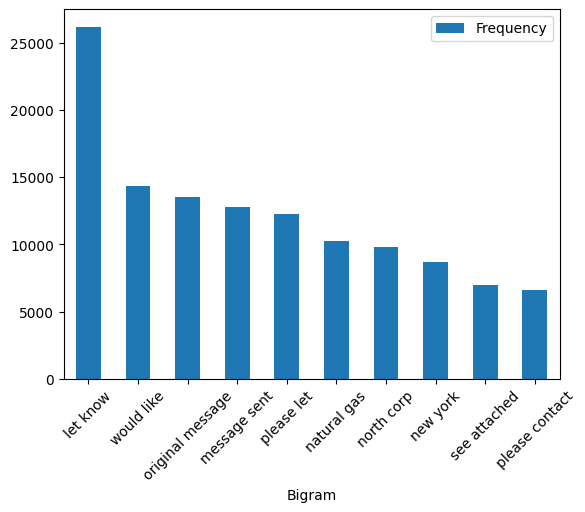

In [ ]:
sorted_total_occurence_per_features = pd.DataFrame(
    {
        "Bigram": feature_names,
        "Frequency": total_occurence_per_features,
    }
).sort_values(by = "Frequency", ascending = False)

top_10_bigrams = sorted_total_occurence_per_features.nlargest(10, "Frequency")

ax = top_10_bigrams.plot(
    x = "Bigram",
    kind = "bar",
)

plt.xticks(rotation=45)

## Data Modelling

### Count Vectorizer

In [28]:
count_vectorizer = CountVectorizer()
word_embedding = count_vectorizer.fit_transform(preprocessed_dataset).T
feature_names = count_vectorizer.get_feature_names_out()
print(word_embedding.shape)
print(len(feature_names))

(28972, 128103)
28972


Use TruncatedSVD to reduce the dimension of the data.

In [ ]:
truncated_svd = TruncatedSVD(n_components = 2)
word_embedding_truncated = truncated_svd.fit_transform(word_embedding)

word_embedding_df = pd.DataFrame(
  word_embedding_truncated,
  index = feature_names
)

word_embedding_df.head()

,0,1
aa,4.782788,-0.168102
aal,0.001409,0.007120
aba,0.203937,0.031125
abac,0.003777,0.002620
aback,0.498859,-0.065347


In [ ]:
word_embedding_df.describe()

,0,1
count,2.897200e+04,28972.000000
mean,3.711823e+00,0.598043
std,3.071239e+01,10.819180
min,-1.321793e-41,-484.592308
25%,6.065973e-03,-0.010327
50%,9.907235e-02,0.003196
75%,6.433835e-01,0.072853
max,2.296073e+03,737.617463


Visualize the embedding data with plotly.

In [ ]:
fig = go.Figure()

fig = px.scatter(
    word_embedding_df,
    y=1,
    x=0,
    text = word_embedding_df.index,
    title = "Count Vectorizer Word Embedding",
)

fig.update_traces(marker_size=10)

plotly_save_path = "drive/MyDrive/Plotly Graphs/enron_email_count_vectorizer_plotly.html"
plotly.offline.plot(fig, filename = plotly_save_path, include_mathjax='cdn', auto_open=False)
fig.show()

### TF-IDF

In [ ]:
tf_idf_vectorizer = TfidfVectorizer()
word_embedding = tf_idf_vectorizer.fit_transform(preprocessed_dataset).T
feature_names = tf_idf_vectorizer.get_feature_names_out()
print(word_embedding.shape)
print(len(feature_names))

(28972, 128103)
28972


In [ ]:
truncated_svd = TruncatedSVD(n_components = 2)
word_embedding_truncated = truncated_svd.fit_transform(word_embedding)

word_embedding_df = pd.DataFrame(
  word_embedding_truncated,
  index = feature_names
)

word_embedding_df.head()

,0,1
aa,0.238941,-0.035733
aal,0.000202,-0.000073
aba,0.025416,-0.003011
abac,0.000397,-0.000143
aback,0.001956,-0.000905


In [ ]:
fig = go.Figure()

fig = px.scatter(
    word_embedding_df,
    y=1,
    x=0,
    text = word_embedding_df.index,
    title = "TF-IDF Vectorizer Word Embedding",
)

fig.update_traces(marker_size=10)

plotly_save_path = "drive/MyDrive/Plotly Graphs/enron_email_tf_idf_vectorizer_plotly.html"
plotly.offline.plot(fig, filename = plotly_save_path, include_mathjax='cdn', auto_open=False)
fig.show()

### Word2Vec

Train the model.

In [ ]:
from nltk import word_tokenize

def get_tokenized_sentence(sentences):
  nltk.download('punkt')
  return word_tokenize(sentences)

count_vectorizer = CountVectorizer()
_ = count_vectorizer.fit_transform(preprocessed_dataset).T
feature_names = count_vectorizer.get_feature_names_out()

# joined_preprocessed_dataset = " ".join(preprocessed_dataset)

tokenized_sentences = []

for sentence in preprocessed_dataset:
  tokenized_sentence = word_tokenize(sentence)
  tokenized_sentences.append(tokenized_sentence)

# tokens = get_tokenized_sentence(joined_preprocessed_dataset)
tokenized_sentences[:10]

In [79]:
from gensim.test.utils import common_texts

word_2_vec_model = gensim.models.Word2Vec(
    sentences = tokenized_sentences,
    vector_size = 2,
    min_count = 1,
)

word_2_vec_model.train(tokenized_sentences,
                       total_examples = len(tokenized_sentences),
                       epochs = 5)
word_2_vec_model

In [80]:
save_path = "drive/MyDrive/Models/word2vec_enron_emails.model"

Save the word2vec model, so we don't have to wait the model to train again.

In [81]:
word_2_vec_model.save(save_path)

Load the saved word2vec model.

In [6]:
word_2_vec_model = gensim.models.Word2Vec.load(save_path)
word_2_vec_model

In [86]:
word_2_vec_dict = dict()

for word in word_2_vec_model.wv.key_to_index:
  word_2_vec_dict[word] = word_2_vec_model.wv.get_vector(word)

### Neural Network Embeddings

## BONUS

BONUS: I don't plot these data in 3D, because rendering plotly graph in google colab is slower. Nonetheless, here's the code.

In [ ]:
# register_plotly_resampler(mode='auto')

# fig.add_trace(
#     go.Scatter3d(
#       x=word_embedding_df[0],
#       y=word_embedding_df[1],
#       z=word_embedding_df[2],
#       # size_max = 3,
#       text = word_embedding_df.index,
#       mode='markers',
#     )
# )

# plotly.offline.plot(fig, filename = 'enron_email_count_vectorizer_plotly.html', include_mathjax='cdn', auto_open=False)